In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from scipy import stats

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, mean_squared_error
from sklearn.metrics import plot_precision_recall_curve,average_precision_score

from sklearn.preprocessing import StandardScaler


sns.set(color_codes = True)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# plt.style.use('fivethirtyeight')

%matplotlib inline

# warnings.filterwarnings('ignore')

In [2]:
data_file = 'IBM-Employee-Attrition.csv'

# import cafe listings into dataframe
emp = pd.read_csv(data_file)

emp = emp.drop(columns=['EmployeeCount', 'EmployeeNumber','Over18','StandardHours'])


attrition_map={'Yes':1,'No':0}
emp['Attrition'] = emp['Attrition'].map(attrition_map)

In [4]:
emp.head()

Age  Attrition     BusinessTravel  DailyRate              Department  DistanceFromHome  Education EducationField  EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel                JobRole  JobSatisfaction MaritalStatus  MonthlyIncome  MonthlyRate  NumCompaniesWorked OverTime  PercentSalaryHike  PerformanceRating  RelationshipSatisfaction  StandardHours  StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager
0   41          1      Travel_Rarely       1102                   Sales                 1          2  Life Sciences                        2  Female          94               3         2        Sales Executive                4        Single           5993        19479                   8      Yes                 11                  3                         1             80                 0                  8                      0                1               6                   4                        0                     5
1   49          0  Travel_Frequently        279  Research & Development                 8          1  Life Sciences                        3    Male          61               2         2     Research Scientist                2       Married           5130        24907                   1       No                 23                  4                         4             80                 1                 10                      3                3              10                   7                        1                     7
2   37          1      Travel_Rarely       1373  Research & Development                 2          2          Other                        4    Male          92               2         1  Laboratory Technician                3        Single           2090         2396                   6      Yes                 15                  3                         2             80                 0                  7                      3                3               0                   0                        0                     0
3   33          0  Travel_Frequently       1392  Research & Development                 3          4  Life Sciences                        4  Female          56               3         1     Research Scientist                3       Married           2909        23159                   1      Yes                 11                  3                         3             80                 0                  8                      3                3               8                   7                        3                     0
4   27          0      Travel_Rarely        591  Research & Development                 2          1        Medical                        1    Male          40               3         1  Laboratory Technician                2       Married           3468        16632                   9       No                 12                  3                         4             80                 1                  6                      3                3               2                   2                        2                     2

In [5]:
emp.shape

(1470, 32)

In [3]:
# get all numerical columns
numerical_dtypes = ['int16','int32', 'int64','float16','float32','float64']
num_cols = []
for i in emp.columns:
    if emp[i].dtype in numerical_dtypes:
        num_cols.append(i)
        
print(len(num_cols))
print(num_cols)

25
['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [4]:
# get all category columns

# cat_cols = list(set(emp.columns) - set(num_cols))

cat_cols = emp.columns.difference(num_cols)
print(len(cat_cols))
print(cat_cols)

7
Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime'], dtype='object')


In [5]:
attri_yes = emp[emp.Attrition==1]
attri_no =  emp[emp.Attrition==0]

In [6]:
def plot_pair_charts(data1, data2, column_list, legend_text,fig_size):
    fig = plt.figure(figsize=fig_size)
    fig.subplots_adjust(hspace=1, wspace=0.5, top=0.96)
    fig.suptitle('Attrtion Yes vs No')

    for i, col in enumerate(list(data1[column_list]),1):
        # print(col)
        ax = fig.add_subplot(len(column_list), 3, i)
        plt.hist(data1[col],alpha=0.8)
        plt.hist(data2[col],alpha=0.8)
        plt.xlabel('{}'.format(col), size=15,labelpad=12.5)
        plt.ylabel('Frequecy', size=15, labelpad=12.5)
        plt.legend(legend_text)
        plt.xticks(rotation=45)
    
    #figname = 'High vs Low quality houses.png'
    # fig.savefig(figname,transparent=False, bbox_inches='tight', dpi=300)
    
    plt.show()

In [7]:
emp.EducationField.unique()

array(['Life Sciences', 'Other', 'Medical', 'Marketing',
       'Technical Degree', 'Human Resources'], dtype=object)

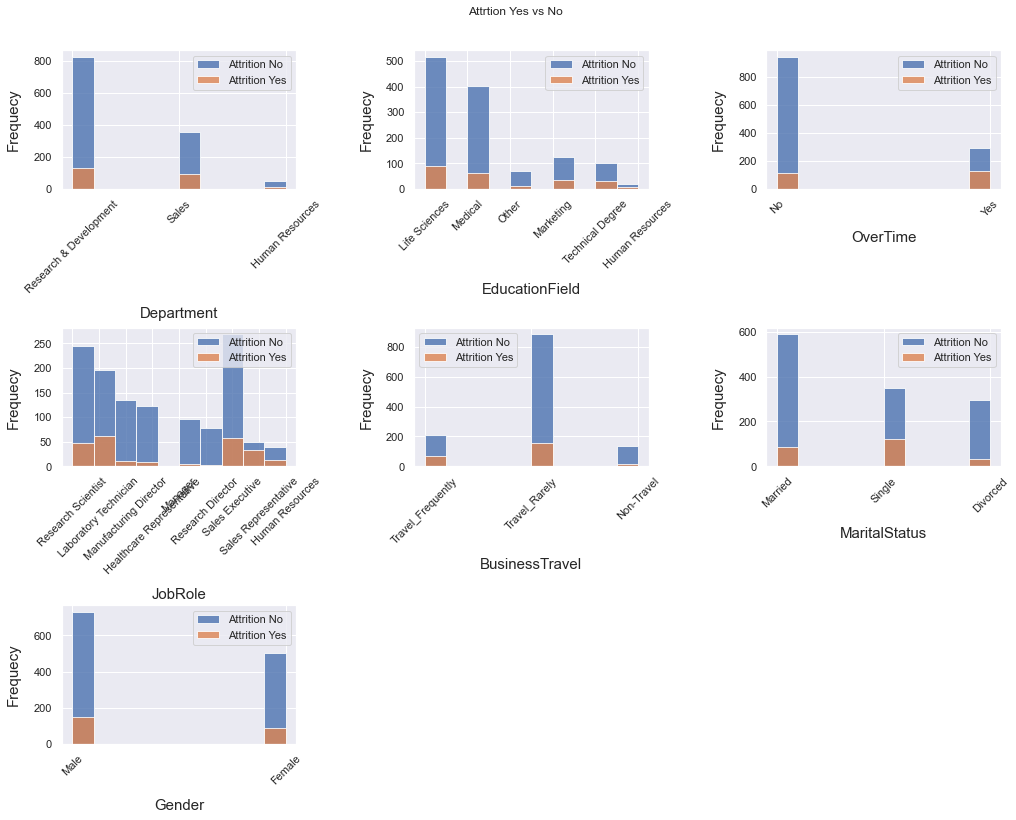

In [238]:
# plot bar charts of ordinal features 
cols_to_plot = cat_cols
plot_pair_charts(attri_no,attri_yes,cols_to_plot,legend_text=['Attrition No','Attrition Yes'],fig_size=(15, 30))   

In [8]:
total_attrition = emp[(emp.Attrition==1)]

age_under_25 = emp[(emp.Age<25) & (emp.Attrition==1)]
age_25_40 = emp[(emp.Age>=25) & (emp.Age<=40) & (emp.Attrition==1)]
age_40_50 = emp[(emp.Age>40) & (emp.Age<=50) & (emp.Attrition==1)]
age_above_50 = emp[(emp.Age>50) & (emp.Attrition==1)]


age_under_25_male = age_under_25[age_under_25.Gender=='Male']
age_under_25_female = age_under_25[age_under_25.Gender=='Female']
age_25_40_male = age_25_40[age_25_40.Gender=='Male']
age_40_50_male = age_40_50[age_40_50.Gender=='Male']
age_above_50_male = age_above_50[age_above_50.Gender=='Male']

age_25_40_male_overtime = emp[(emp.Age>=25) & (emp.Age<=40) & (emp.Gender=='Male') & (emp.OverTime=='Yes') & (emp.Attrition==1)].shape[0] 

attri_by_departments = attri_yes.groupby('Department')



In [10]:
genZ = emp[(emp.Age<=22) & (emp.Attrition==1)]
genY_millenials = emp[(emp.Age>=23) & (emp.Age<=38) & (emp.Attrition==1)]
genX = emp[(emp.Age>=39) & (emp.Age<=54) & (emp.Attrition==1)]
boomers = emp[(emp.Age>54) & (emp.Attrition==1)]

# genZ_male = genZ[genZ.GenderMale==1]
# genY_millenials_male = genY_millenials[genY_millenials.GenderMale==1]
# genX_male = genX[genX.GenderMale==1]
# boomers_male = boomers[boomers.GenderMale==1]

genZ_male = genZ[genZ.Gender=='Male']
genY_millenials_male = genY_millenials[genY_millenials.Gender=='Male']
genX_male = genX[genX.Gender=='Male']
boomers_male = boomers[boomers.Gender=='Male']

In [11]:
age_under_25_male

Age  Attrition     BusinessTravel  DailyRate              Department  DistanceFromHome  Education    EducationField  EnvironmentSatisfaction Gender  HourlyRate  JobInvolvement  JobLevel                JobRole  JobSatisfaction MaritalStatus  MonthlyIncome  MonthlyRate  NumCompaniesWorked OverTime  PercentSalaryHike  PerformanceRating  RelationshipSatisfaction  StandardHours  StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager
34     24          1      Travel_Rarely        813  Research & Development                 1          3           Medical                        2   Male          61               3         1     Research Scientist                4       Married           2293         3020                   2      Yes                 16                  3                         1             80                 1                  6                      2                2               2                   0                        2                     0
127    19          1      Travel_Rarely        528                   Sales                22          1         Marketing                        4   Male          50               3         1   Sales Representative                3        Single           1675        26820                   1      Yes                 19                  3                         4             80                 0                  0                      2                2               0                   0                        0                     0
177    19          1      Travel_Rarely        303  Research & Development                 2          3     Life Sciences                        2   Male          47               2         1  Laboratory Technician                4        Single           1102         9241                   1       No                 22                  4                         3             80                 0                  1                      3                2               1                   0                        1                     0
296    18          1      Travel_Rarely        230  Research & Development                 3          3     Life Sciences                        3   Male          54               3         1  Laboratory Technician                3        Single           1420        25233                   1       No                 13                  3                         3             80                 0                  0                      2                3               0                   0                        0                     0
422    19          1      Travel_Rarely        489         Human Resources                 2          2  Technical Degree                        1   Male          52               2         1        Human Resources                4        Single           2564        18437                   1       No                 12                  3                         3             80                 0                  1                      3                4               1                   0                        0                     0
443    22          1  Travel_Frequently       1368  Research & Development                 4          1  Technical Degree                        3   Male          99               2         1  Laboratory Technician                3        Single           3894         9129                   5       No                 16                  3                         3             80                 0                  4                      3                3               2                   2                        1                     2
457    18          1  Travel_Frequently       1306                   Sales                 5          3         Marketing                        2   Male          69               3         1   Sales Representati

In [13]:
age_25_40.shape[0] / total_attrition.shape[0] 

0.620253164556962

In [11]:
age_25_40_male / age_25_40 

0.6530612244897959

In [22]:
age_25_40_male_overtime / age_25_40_male

0.5208333333333334

In [17]:
overtime = emp[(emp.OverTime=='Yes') & (emp.Attrition==1)]
overtime.shape[0] / total_attrition


0.5358649789029536

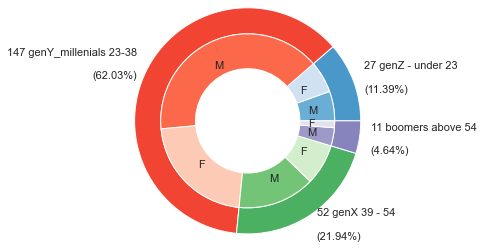

In [14]:


# Make data: I have 3 groups and 7 subgroups
group_names=['genZ - under 23', 'genY_millenials 23-38', 'genX 39 - 54', 'boomers above 54']
group_size=[genZ.shape[0],genY_millenials.shape[0],genX.shape[0],boomers.shape[0]]
pcts = [f'{s} {l}\n\n({s*100/sum(group_size):.2f}%)' for s,l in zip(group_size, group_names)]


subgroup_names=['M', 'F', 'M', 'F', 'M', 'F', 'M', 'F']
subgroup_size=[genZ_male.shape[0], genZ.shape[0]-genZ_male.shape[0],
               genY_millenials_male.shape[0], genY_millenials.shape[0]-genY_millenials_male.shape[0],
               genX_male.shape[0], genX.shape[0]-genX_male.shape[0],
               boomers_male.shape[0], boomers.shape[0]-boomers_male.shape[0]
              ]

# Create colors
a, b, c, d =[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]

# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=pcts, colors=[a(0.6), b(0.6), c(0.6), d(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')


# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.2), b(0.5), b(0.2), c(0.5), c(0.2), d(0.5), d(0.2)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

# show it
plt.show()


In [ ]:

size_list = list(feature_importance_df.score)
label_list = list(feature_importance_df.feature)

# group_names=['genZ - under 23', 'genY_millenials 23-38', 'genX 39 - 54', 'boomers above 54']
# group_size=[genZ.shape[0],genY_millenials.shape[0],genX.shape[0],boomers.shape[0]]


# pcts = [f'{s} {l}\n\n({s*100/sum(group_size):.2f}%)' for s,l in zip(group_size, group_names)]



# Create colors
a, b, c, d =[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]

# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(size_list, radius=1.3, labels=label_list, colors=[a(0.6), b(0.6), c(0.6), d(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')


# show it
plt.show()


(array([2., 3., 4., 3., 5., 6., 2., 0., 0., 2.]),
 array([1009. , 1325.2, 1641.4, 1957.6, 2273.8, 2590. , 2906.2, 3222.4,
        3538.6, 3854.8, 4171. ]),
 <a list of 10 Patch objects>)

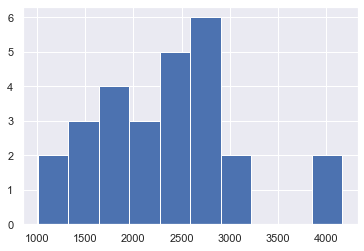

In [15]:
# plt.hist(genY_millenials.MonthlyIncome)
plt.hist(genZ.MonthlyIncome)
# plt.hist(boomers.MonthlyIncome)

# plt.hist(emp.Age)

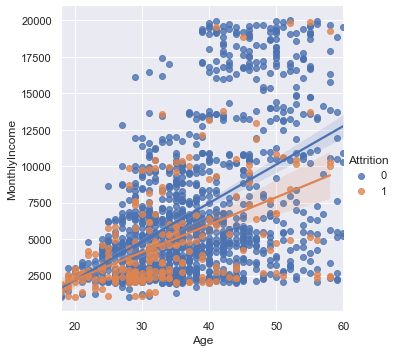

In [323]:
sns.lmplot(data=emp, x='Age',y='MonthlyIncome',hue='Attrition')

In [89]:
departments = emp.Department.unique()
size=len(departments)
departments[0]

'Sales'

In [82]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [ ]:
emp.groupby('JobRole').agg
plt.xticks(rotation=90)

In [12]:
emp.describe().T

count          mean          std     min     25%      50%       75%      max
Age                       1470.0     36.923810     9.135373    18.0    30.0     36.0     43.00     60.0
Attrition                 1470.0      0.161224     0.367863     0.0     0.0      0.0      0.00      1.0
DailyRate                 1470.0    802.485714   403.509100   102.0   465.0    802.0   1157.00   1499.0
DistanceFromHome          1470.0      9.192517     8.106864     1.0     2.0      7.0     14.00     29.0
Education                 1470.0      2.912925     1.024165     1.0     2.0      3.0      4.00      5.0
EnvironmentSatisfaction   1470.0      2.721769     1.093082     1.0     2.0      3.0      4.00      4.0
HourlyRate                1470.0     65.891156    20.329428    30.0    48.0     66.0     83.75    100.0
JobInvolvement            1470.0      2.729932     0.711561     1.0     2.0      3.0      3.00      4.0
JobLevel                  1470.0      2.063946     1.106940     1.0     1.0      2.0      3.00      5.0
JobSatisfaction           1470.0      2.728571     1.102846     1.0     2.0      3.0      4.00      4.0
MonthlyIncome             1470.0   6502.931293  4707.956783  1009.0  2911.0   4919.0   8379.00  19999.0
MonthlyRate               1470.0  14313.103401  7117.786044  2094.0  8047.0  14235.5  20461.50  26999.0
NumCompaniesWorked        1470.0      2.693197     2.498009     0.0     1.0      2.0      4.00      9.0
PercentSalaryHike         1470.0     15.209524     3.659938    11.0    12.0     14.0     18.00     25.0
PerformanceRating         1470.0      3.153741     0.360824     3.0     3.0      3.0      3.00      4.0
RelationshipSatisfaction  1470.0      2.712245     1.081209     1.0     2.0      3.0      4.00      4.0
StandardHours             1470.0     80.000000     0.000000    80.0    80.0     80.0     80.00     80.0
StockOptionLevel          1470.0      0.793878     0.852077     0.0     0.0      1.0      1.00      3.0
TotalWorkingYears         1470.0     11.279592     7.780782     0.0     6.0     10.0     15.00     40.0
TrainingTimesLastYear     1470.0      2.799320     1.289271     0.0     2.0      3.0      3.00      6.0
WorkLifeBalance           1470.0      2.761224     0.706476     1.0     2.0      3.0      3.00      4.0
YearsAtCompany            1470.0      7.008163     6.126525     0.0     3.0      5.0      9.00     40.0
YearsInCurrentRole        1470.0      4.229252     3.623137     0.0     2.0      3.0      7.00     18.0
YearsSinceLastPromotion   1470.0      2.187755     3.222430     0.0     0.0      1.0      3.00     15.0
YearsWithCurrManager      1470.0      4.123129     3.568136     0.0     2.0      3.0      7.00     17.0

(array([57., 62., 33., 47.,  0.,  2., 12.,  9., 10.,  5.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

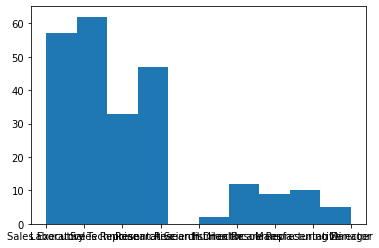

In [138]:
# attri_yes.groupby('JobRole').plot.barh()

plt.hist(attri_yes.JobRole)


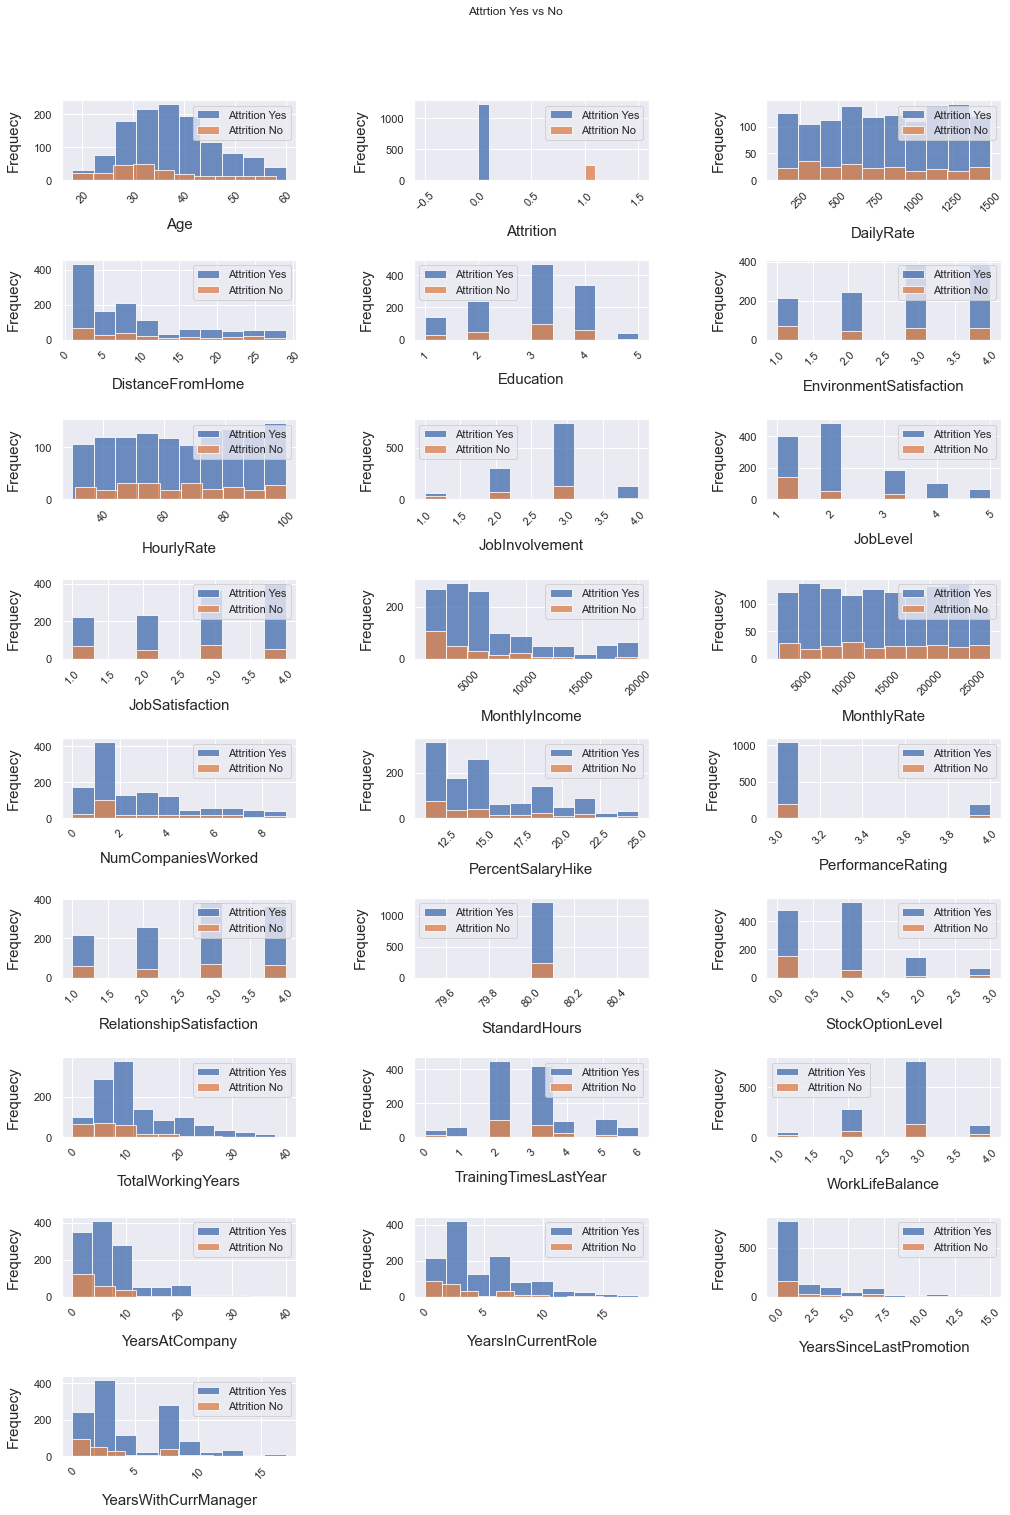

In [247]:
# plot bar charts of numerial features 
cols_to_plot = num_cols
plot_pair_charts(attri_no,attri_yes,cols_to_plot,legend_text=['Attrition Yes','Attrition No'],fig_size=(15, 65))   

In [22]:
# plot MontlyIncome of all numerical columns

def plot_multi_charts(data, x_column_list, y, title, y_label, plot_type, figsize):
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.975)
    fig.suptitle(title)

    for i, col in enumerate(list(data[x_column_list]),1):
        
        ax = fig.add_subplot(len(x_column_list), 3, i)
        
        if plot_type == 'scatter':
            plt.scatter(x=data[col], y=data[y])
            plt.xlabel('{}'.format(col), size=15,labelpad=12.5)
            plt.ylabel(y_label, size=15, labelpad=12.5)
        elif plot_type == 'bar':
            data.groupby(col).agg({y:'mean'}).sort_values(by=y).plot.bar(ax=ax)
    
    figname = title + '.png'
    fig.savefig(figname,transparent=False, bbox_inches='tight', dpi=300)
    
    plt.xticks(rotation=45)
    plt.show()
    

Total cols:  25


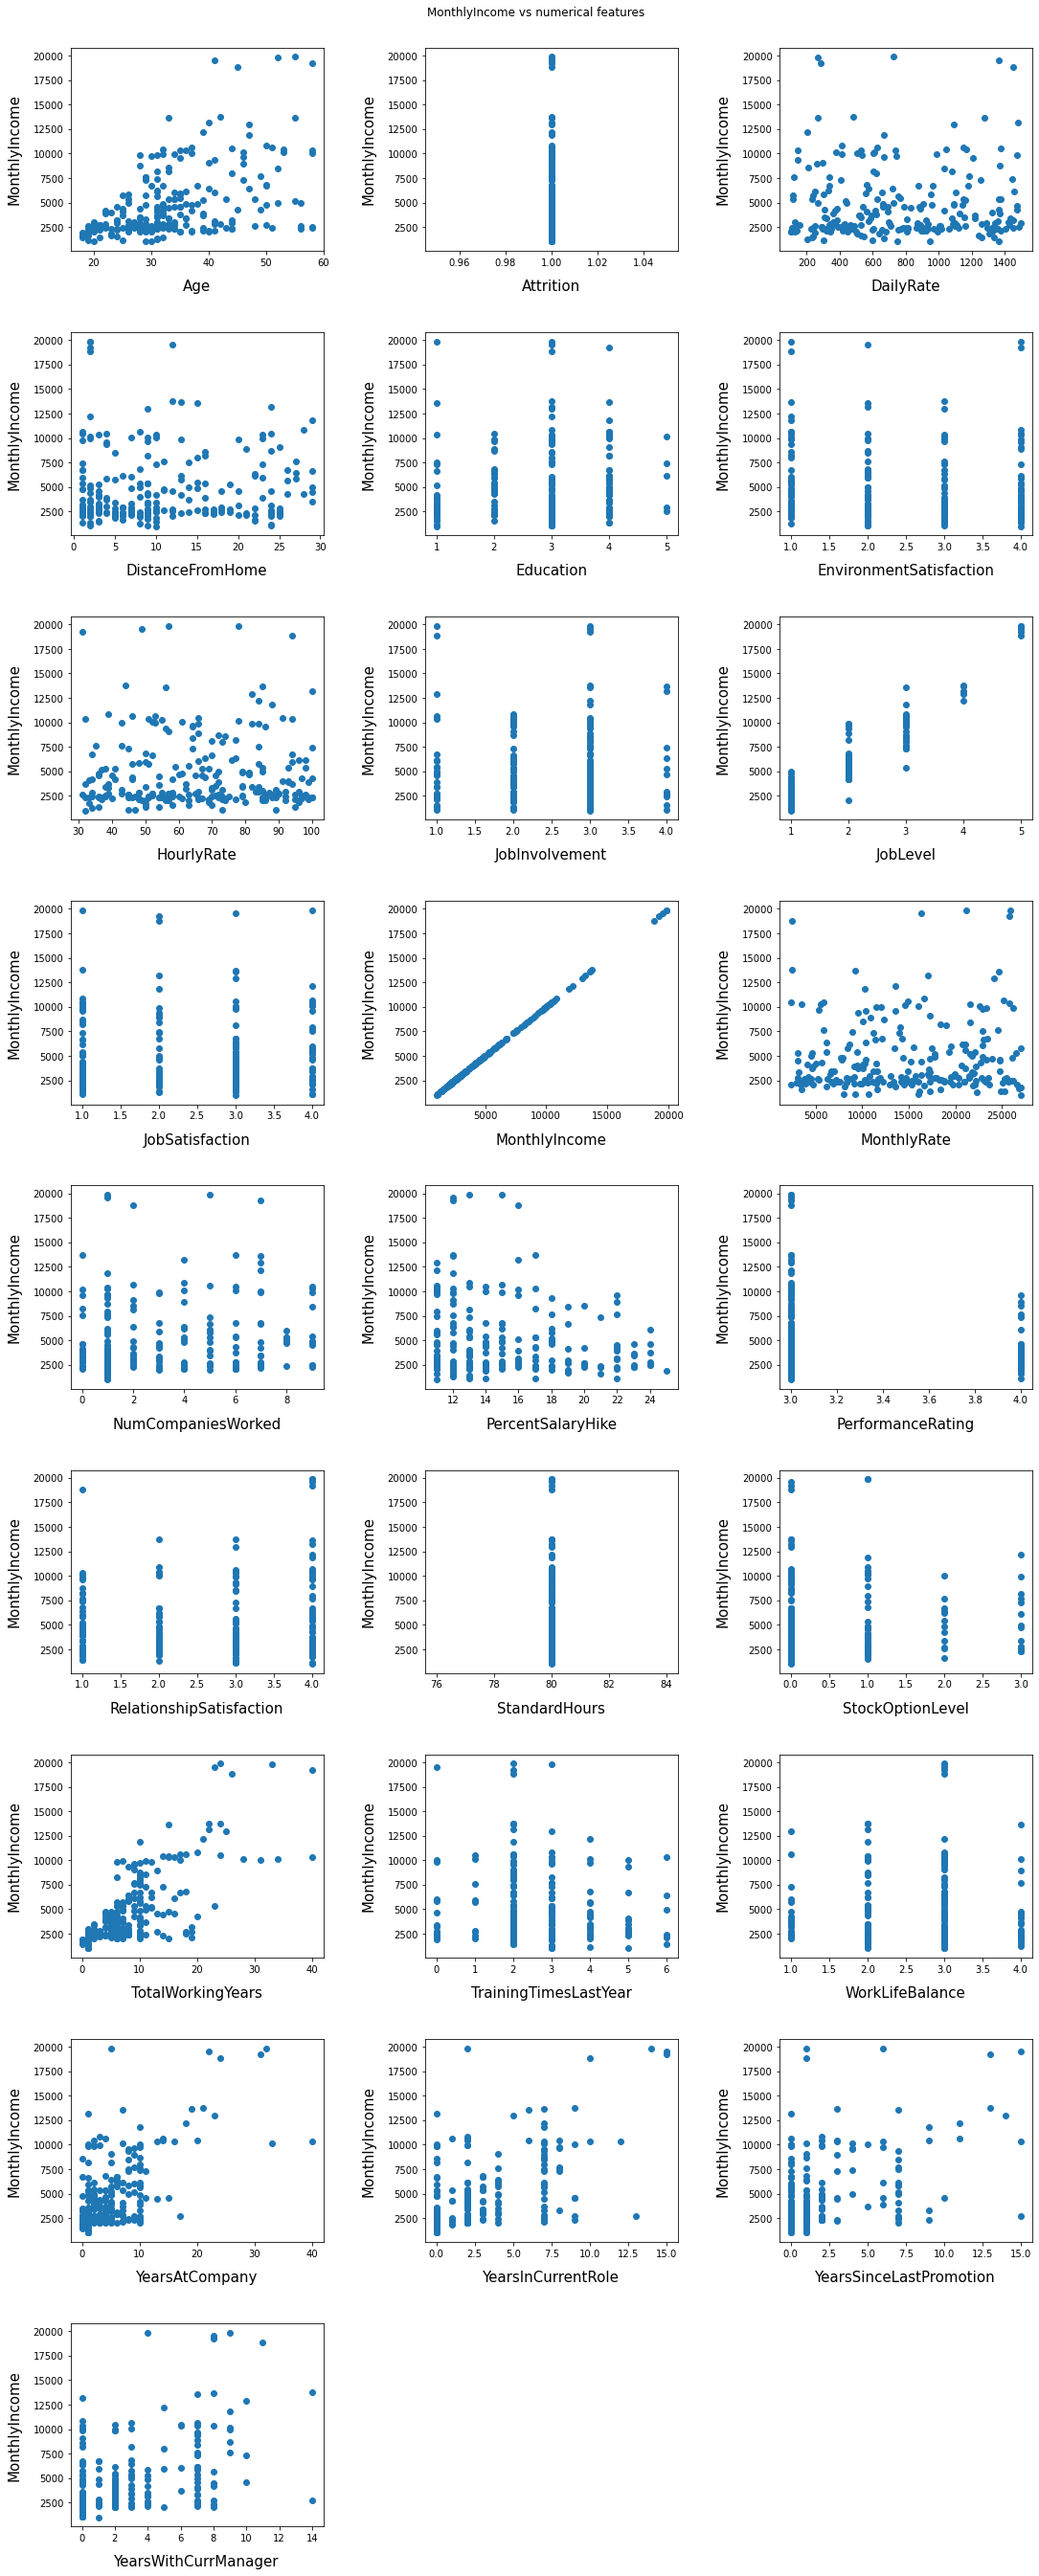

In [159]:
# Observe MonthlyIncome of all numerical features in Attrition Yes subset

plot_multi_charts(data=attri_yes, x_column_list=num_cols,y='MonthlyIncome', 
                  title='MonthlyIncome vs numerical features',y_label='MonthlyIncome',plot_type='scatter',figsize=(18,120))    

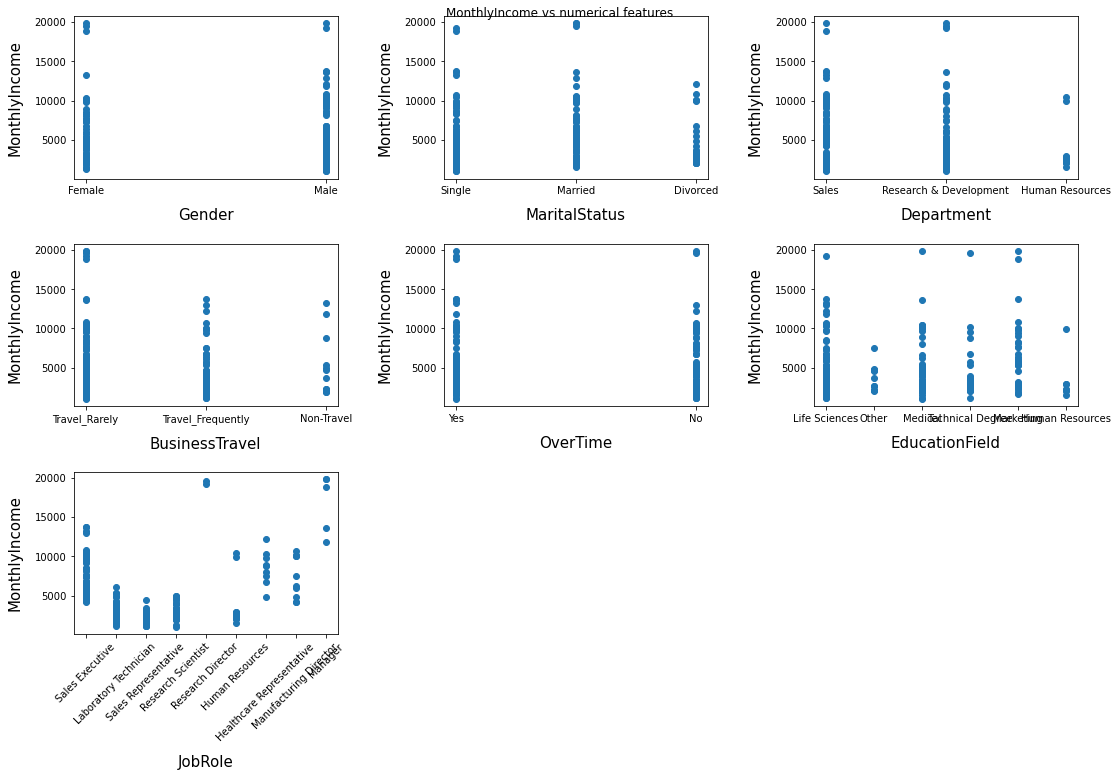

In [172]:
# Observe sale price of all category features in Attrition Yes subset

plot_multi_charts(data=attri_yes, x_column_list=cat_cols,y='MonthlyIncome', 
                  title='MonthlyIncome vs numerical features',y_label='MonthlyIncome',plot_type='scatter',figsize=(18,25))    

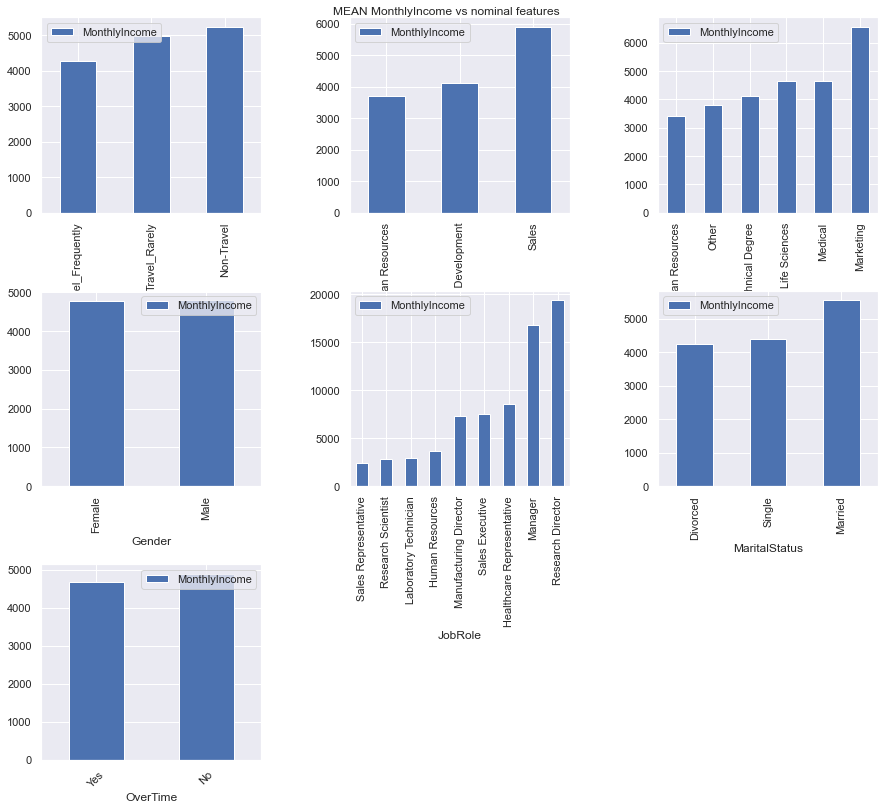

In [23]:
# Observe average sale price of all category features

plot_multi_charts(data=attri_yes, x_column_list=cat_cols, y='MonthlyIncome',
                  title='MEAN MonthlyIncome vs nominal features', y_label='Ave Monthly Income',plot_type='bar',figsize=(15,30))    

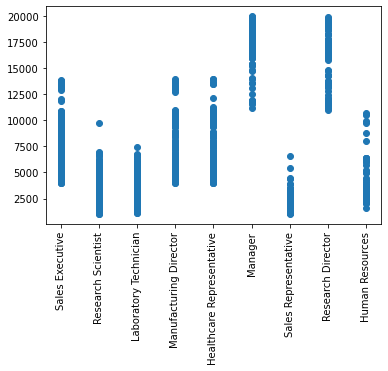

In [170]:
plt.scatter(emp.JobRole,emp.MonthlyIncome)
plt.xticks(rotation=90)
plt.show()

/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


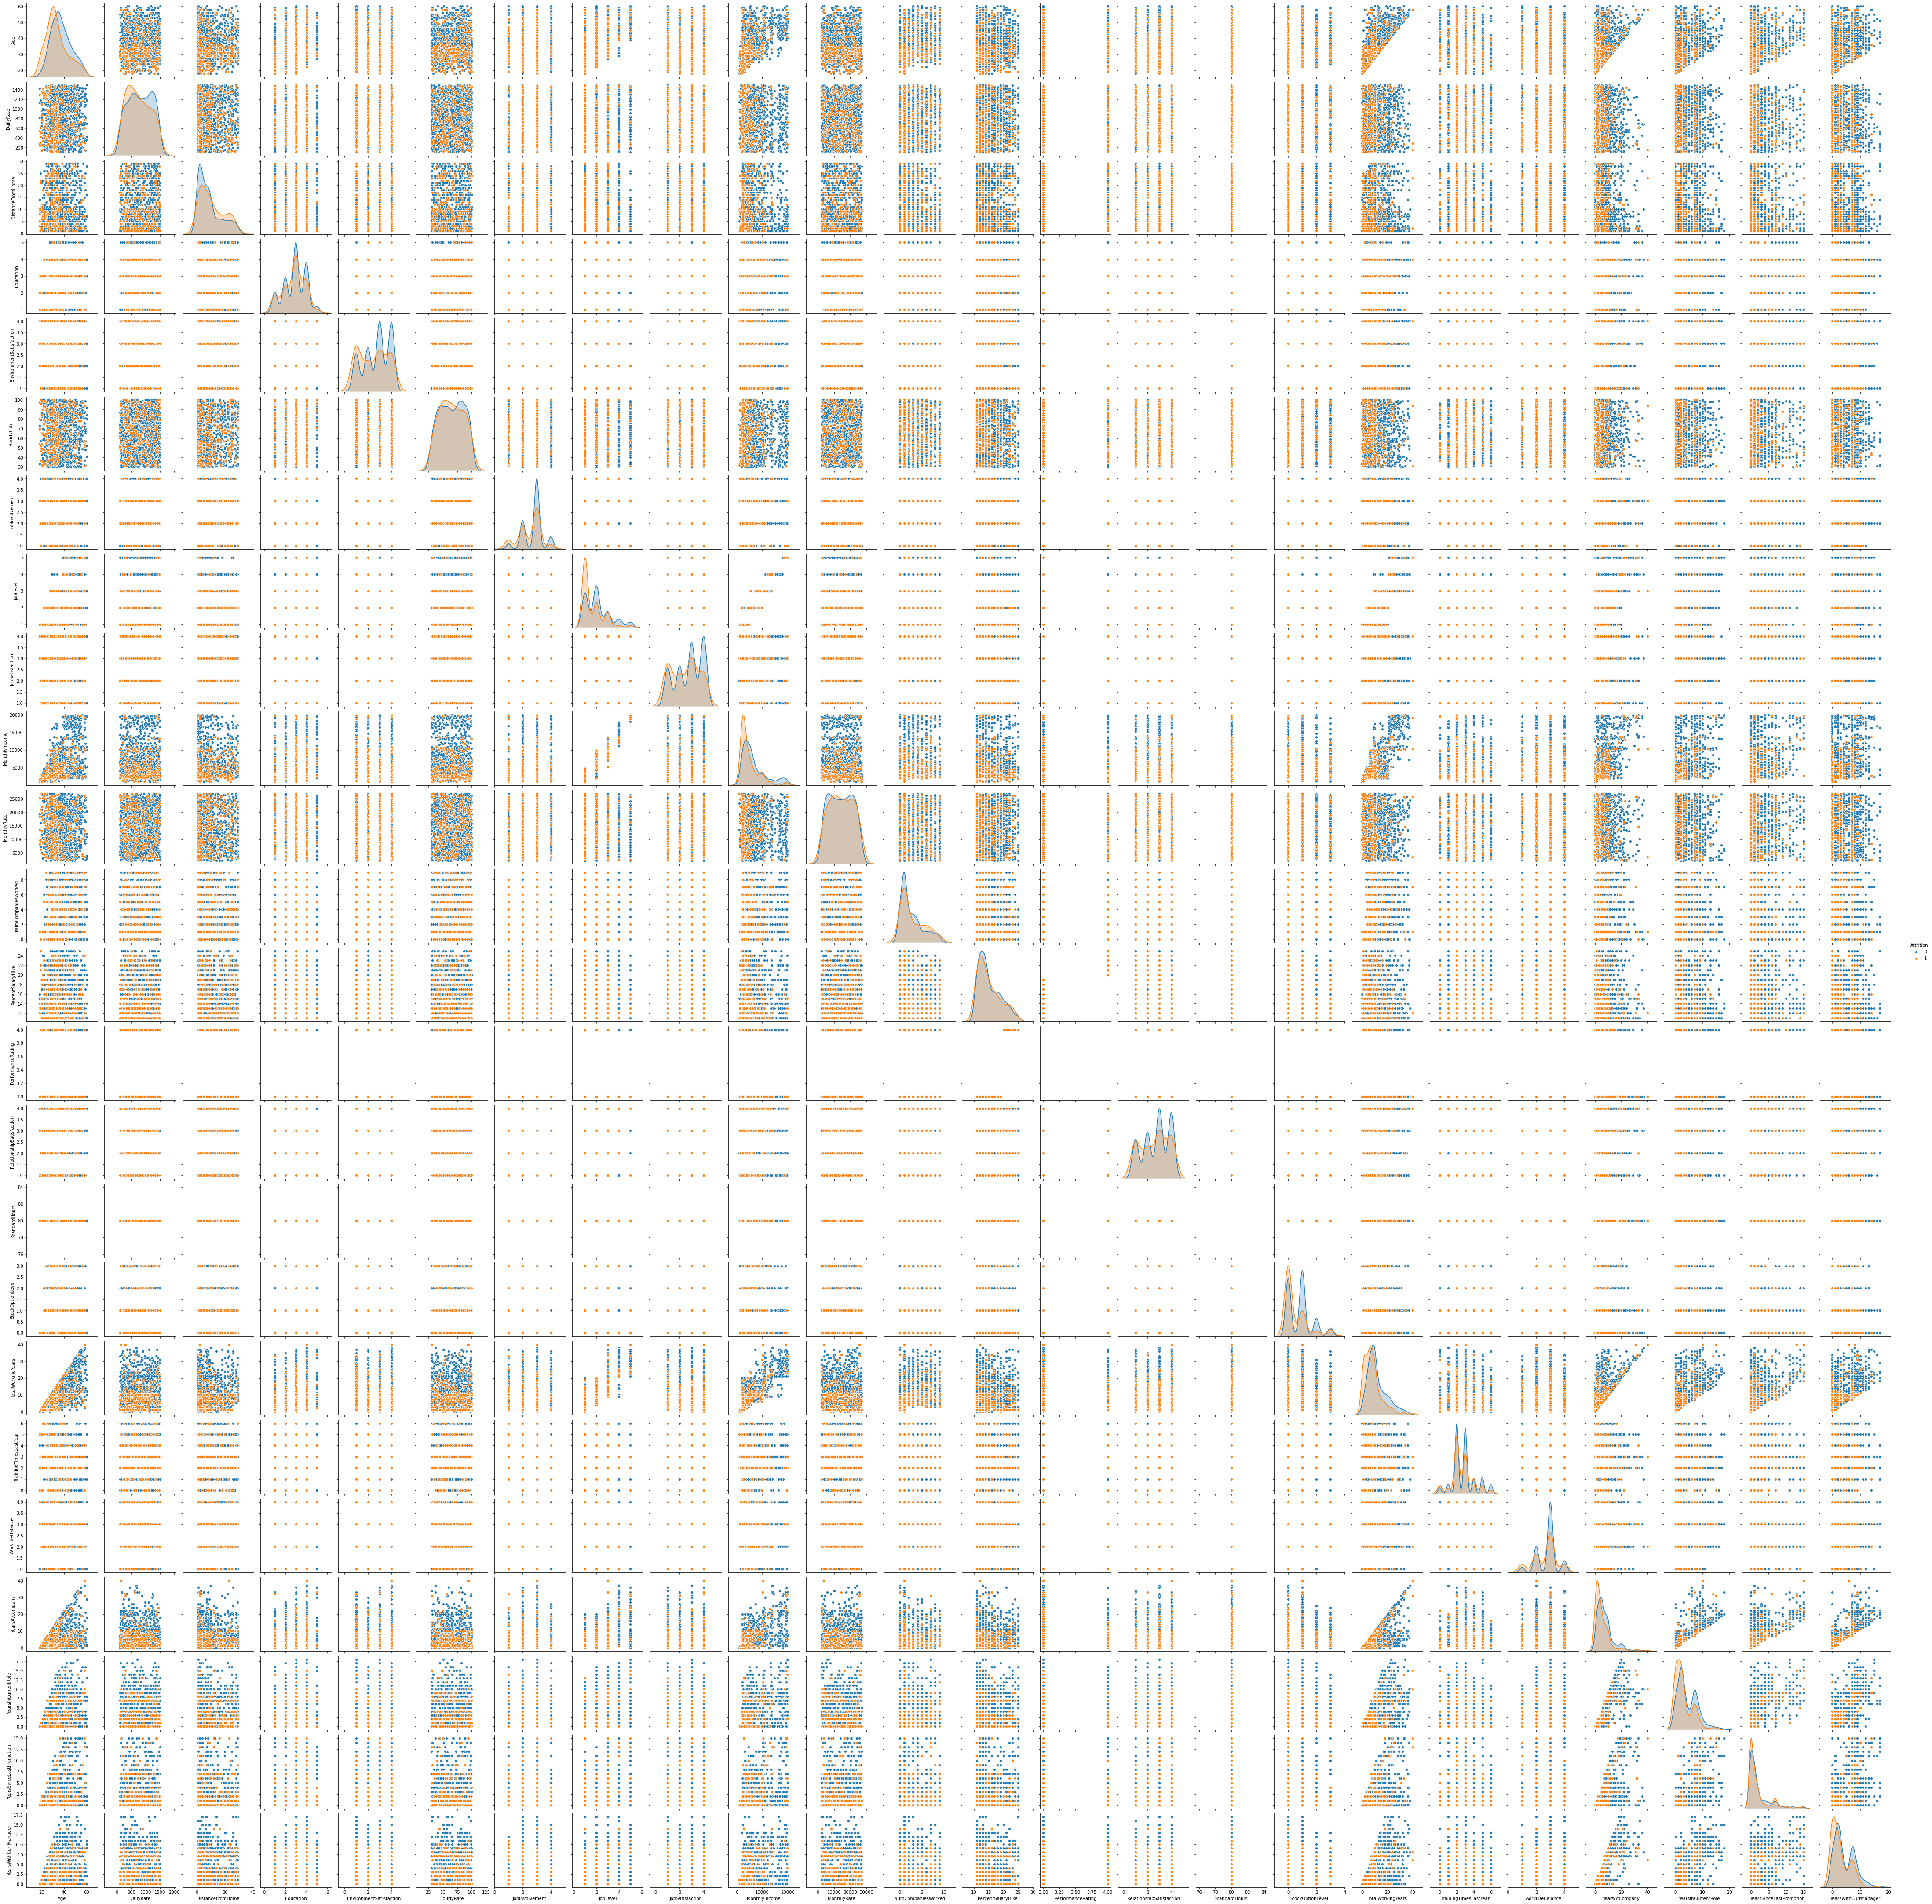

In [112]:
sns.pairplot(data=emp,hue='Attrition')

In [132]:
emp[(emp.OverTime=='Yes') & (emp.Attrition==1)].shape[0] / emp[(emp.Attrition==1)].shape[0]

0.5358649789029536

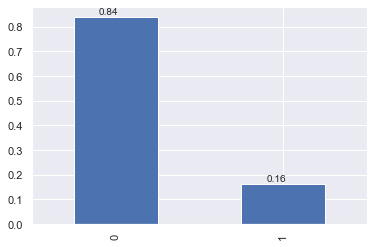

In [11]:
emp['Attrition'].value_counts(normalize=True).plot(kind='bar')

xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(0,2)]
for i, v in enumerate(emp['Attrition'].value_counts(normalize=True)):
    plt.text(xlocs[i] - 1.1, v + 0.01, str(round(v,2)))

plt.show()

## FEATURES ENGINEERING

In [174]:
cat_cols

['Gender',
 'MaritalStatus',
 'Department',
 'BusinessTravel',
 'OverTime',
 'EducationField',
 'JobRole']

In [24]:
gender_map={'Male':1,'Female':0}
emp['GenderMale'] = emp['Gender'].map(gender_map)

overtime_map={'Yes':1,'No':0}
emp['OverTime'] = emp['OverTime'].map(overtime_map)

emp.head()

Age  Attrition     BusinessTravel  DailyRate              Department  DistanceFromHome  Education EducationField  EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel                JobRole  JobSatisfaction MaritalStatus  MonthlyIncome  MonthlyRate  NumCompaniesWorked  OverTime  PercentSalaryHike  PerformanceRating  RelationshipSatisfaction  StandardHours  StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  GenderMale
0   41          1      Travel_Rarely       1102                   Sales                 1          2  Life Sciences                        2  Female          94               3         2        Sales Executive                4        Single           5993        19479                   8         1                 11                  3                         1             80                 0                  8                      0                1               6                   4                        0                     5           0
1   49          0  Travel_Frequently        279  Research & Development                 8          1  Life Sciences                        3    Male          61               2         2     Research Scientist                2       Married           5130        24907                   1         0                 23                  4                         4             80                 1                 10                      3                3              10                   7                        1                     7           1
2   37          1      Travel_Rarely       1373  Research & Development                 2          2          Other                        4    Male          92               2         1  Laboratory Technician                3        Single           2090         2396                   6         1                 15                  3                         2             80                 0                  7                      3                3               0                   0                        0                     0           1
3   33          0  Travel_Frequently       1392  Research & Development                 3          4  Life Sciences                        4  Female          56               3         1     Research Scientist                3       Married           2909        23159                   1         1                 11                  3                         3             80                 0                  8                      3                3               8                   7                        3                     0           0
4   27          0      Travel_Rarely        591  Research & Development                 2          1        Medical                        1    Male          40               3         1  Laboratory Technician                2       Married           3468        16632                   9         0                 12                  3                         4             80                 1                  6                      3                3               2                   2                        2                     2           1

In [25]:
# get all numerical columns
numerical_dtypes = ['int16','int32', 'int64','float16','float32','float64']
        
num_cols = [i for i in emp.columns if emp[i].dtype in numerical_dtypes]        
        
print(len(num_cols))
print(num_cols)

27
['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'GenderMale']


In [27]:
# get all category columns


emp = emp.drop(columns=['Gender'])

cat_cols = emp.columns.difference(num_cols)

print(len(cat_cols))
print(cat_cols)

5
Index(['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus'], dtype='object')


In [28]:
# HOT ENCODE nominal cols

emp = pd.get_dummies(data = emp, columns = cat_cols)
emp.head()

Age  Attrition  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  HourlyRate  JobInvolvement  JobLevel  JobSatisfaction  MonthlyIncome  MonthlyRate  NumCompaniesWorked  OverTime  PercentSalaryHike  PerformanceRating  RelationshipSatisfaction  StandardHours  StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  GenderMale  BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  BusinessTravel_Travel_Rarely  Department_Human Resources  Department_Research & Development  Department_Sales  EducationField_Human Resources  EducationField_Life Sciences  EducationField_Marketing  EducationField_Medical  EducationField_Other  EducationField_Technical Degree  JobRole_Healthcare Representative  JobRole_Human Resources  JobRole_Laboratory Technician  JobRole_Manager  JobRole_Manufacturing Director  JobRole_Research Director  JobRole_Research Scientist  \
0   41          1       1102                 1          2                        2          94               3         2                4           5993        19479                   8         1                 11                  3                         1             80                 0                  8                      0                1               6                   4                        0                     5           0                          0                                 0                             1                           0                                  0                 1                               0                             1                         0                       0                     0                                0                                  0                        0                              0                0                               0                          0                           0   
1   49          0        279                 8          1                        3          61               2         2                2           5130        24907                   1         0                 23                  4                         4             80                 1                 10                      3                3              10                   7                        1                     7           1                          0                                 1                             0                           0                                  1                 0                               0                             1                         0                       0                     0                                0                                  0                        0                              0                0                               0                          0                           1   
2   37          1       1373                 2          2                        4          92               2         1                3           2090         2396                   6         1                 15                  3                         2             80                 0                  7                      3                3               0                   0                        0                     0           1                          0                                 0                             1                           0                                  1                 0                               0                             0                         0                       0                     1                                0                                  0                        0                              1                0                               0                          0                           0   
3   33          0       1392                 3          4          

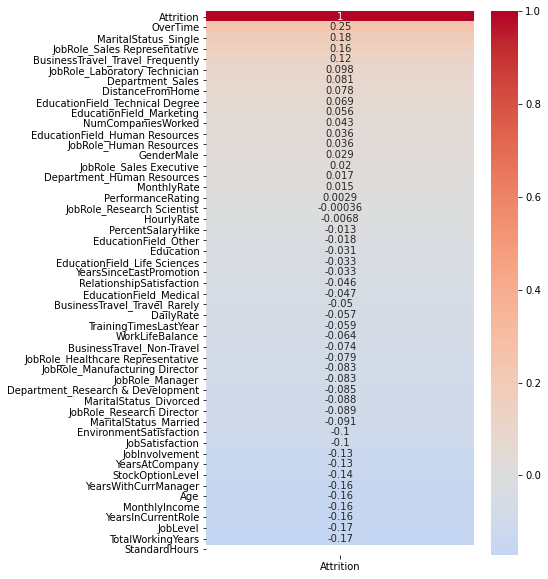

In [183]:
figure = plt.figure(figsize=(6,10))
sns.heatmap(emp.corr()[['Attrition']].sort_values('Attrition',ascending=False),annot=True, cmap='coolwarm', center=0);


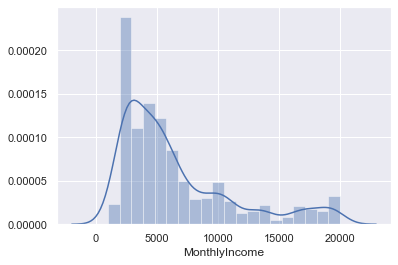

In [29]:

sns.distplot(emp.MonthlyIncome)

In [30]:
# Skew and kurt
print("Skewness: %f" % emp['MonthlyIncome'].skew())
print("Kurtosis: %f" % emp['MonthlyIncome'].kurt())

Skewness: 1.369817
Kurtosis: 1.005233


In [31]:
emp.MonthlyIncome.describe()

count     1470.000000
mean      6502.931293
std       4707.956783
min       1009.000000
25%       2911.000000
50%       4919.000000
75%       8379.000000
max      19999.000000
Name: MonthlyIncome, dtype: float64

In [106]:
emp_income_fitler = emp[(emp.MonthlyIncome < 15000)]

In [50]:
emp['MonthlyIncome2'] = np.log1p(emp['MonthlyIncome'])

In [34]:
emp_income_fitler['MonthlyIncome3'] = np.log1p(emp_income_fitler['MonthlyIncome'])
emp_income_fitler['MonthlyIncome3']

<ipython-input-34-9e617fe41198>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emp_income_fitler['MonthlyIncome3'] = np.log1p(emp_income_fitler['MonthlyIncome'])


0       8.698514
1       8.543056
2       7.645398
3       7.975908
4       8.151622
          ...   
1465    7.852439
1466    9.209540
1467    8.723069
1468    8.592486
1469    8.390496
Name: MonthlyIncome3, Length: 1337, dtype: float64

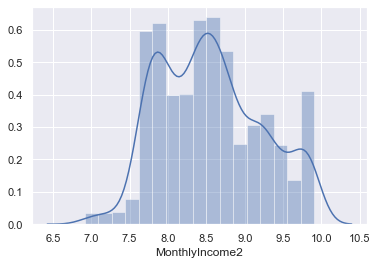

In [35]:

sns.distplot(emp.MonthlyIncome2)

In [36]:
# Skew and kurt
print("Skewness: %f" % emp['MonthlyIncome2'].skew())
print("Kurtosis: %f" % emp['MonthlyIncome2'].kurt())

Skewness: 0.286448
Kurtosis: -0.697564


(array([ 57., 105., 224., 265., 255., 217., 131.,  92.,  77.,  47.]),
 array([18. , 22.2, 26.4, 30.6, 34.8, 39. , 43.2, 47.4, 51.6, 55.8, 60. ]),
 <a list of 10 Patch objects>)

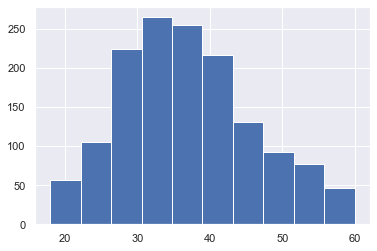

In [37]:
plt.hist(emp.Age)

(array([57.,  0.,  0., 45.,  0.,  0., 71.,  0.,  0., 64.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

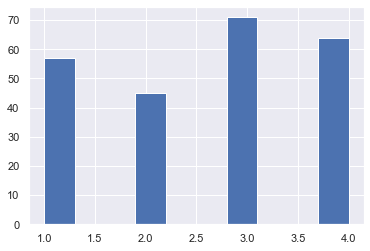

In [38]:
plt.hist(attri_yes.RelationshipSatisfaction)

(array([200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  37.]),
 array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ]),
 <a list of 10 Patch objects>)

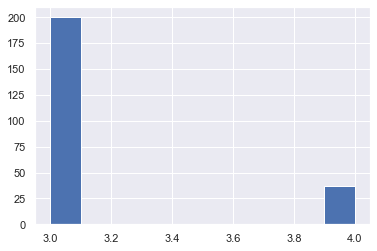

In [39]:

plt.hist(attri_yes.PerformanceRating)

0.6329113924050633

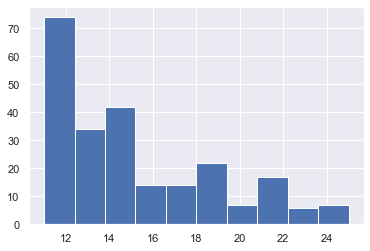

In [40]:

plt.hist(attri_yes.PercentSalaryHike)

attri_yes[attri_yes.PercentSalaryHike <= 15].shape[0] / attri_yes.shape[0]

0.6708860759493671

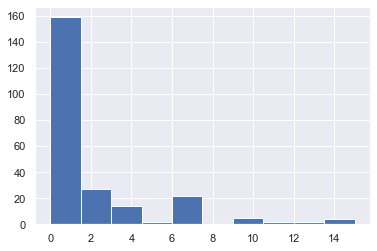

In [41]:
plt.hist(attri_yes.YearsSinceLastPromotion)

attri_yes[attri_yes.YearsSinceLastPromotion <= 1].shape[0] / attri_yes.shape[0]

0.5147679324894515

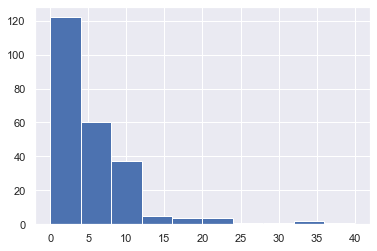

In [42]:
plt.hist(attri_yes.YearsAtCompany)

attri_yes[attri_yes.YearsAtCompany <= 3].shape[0] / attri_yes.shape[0]

In [43]:
plt.scatter(emp_test[emp_test.Age<38].Age, emp_test[emp_test.Age<38].JobRole)

NameError: name 'emp_test' is not defined

# MODELING

In [45]:
JobRole_encoded_cols = [c for c in emp if c.startswith('JobRole_')]
Department_encoded_cols = [c for c in emp if c.startswith('Department_')]
EducationField_encoded_cols = [c for c in emp if c.startswith('EducationField_')]
BusinessTravel_encoded_cols = [c for c in emp if c.startswith('BusinessTravel_')]
MaritalStatus_encoded_cols = [c for c in emp if c.startswith('MaritalStatus_')]
JobRole_encoded_cols

['JobRole_Healthcare Representative',
 'JobRole_Human Resources',
 'JobRole_Laboratory Technician',
 'JobRole_Manager',
 'JobRole_Manufacturing Director',
 'JobRole_Research Director',
 'JobRole_Research Scientist',
 'JobRole_Sales Executive',
 'JobRole_Sales Representative']

In [139]:
cols6 = ['MonthlyIncome','JobSatisfaction','EnvironmentSatisfaction','WorkLifeBalance', 'JobInvolvement',
           'TrainingTimesLastYear','NumCompaniesWorked','JobLevel', 'StockOptionLevel',
           'DistanceFromHome', 'YearsWithCurrManager', 'YearsAtCompany', 'YearsInCurrentRole', 
           'TotalWorkingYears','Age','OverTime','GenderMale']

# feature_cols = cols1 + cols2

filter_cols = ['HourlyRate','DailyRate','MonthlyRate']


target_col = 'Attrition'

# feature_cols = [c for c in emp.columns if c != target_col]

# feature_cols = [c for c in emp.columns if (c != target_col) & (c not in filter_cols)]

# feature_cols = cols3 + cols4

# feature_cols = cols5

feature_cols = cols6 + JobRole_encoded_cols + Department_encoded_cols + EducationField_encoded_cols + BusinessTravel_encoded_cols + MaritalStatus_encoded_cols



X = emp_income_fitler[feature_cols]
 
y = emp_income_fitler['Attrition']

# X = emp[feature_cols]

# y = emp['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [102]:
X_train.shape


(851, 41)

In [48]:
print(feature_cols)

['MonthlyIncome3', 'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'TrainingTimesLastYear', 'NumCompaniesWorked', 'JobLevel', 'StockOptionLevel', 'DistanceFromHome', 'YearsWithCurrManager', 'YearsAtCompany', 'YearsInCurrentRole', 'TotalWorkingYears', 'Age', 'OverTime', 'GenderMale', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'MaritalStatus_Divorced', 'MaritalStatus_Married',

### SMOTE RESAMPLE

In [140]:
from imblearn.over_sampling import SMOTE
from collections import Counter

#Oversampling the data
smote = SMOTE(random_state = 101)
X_sm, y_sm = smote.fit_resample(X, y)
Counter(y_sm)

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm,test_size=0.2,random_state=42)


In [54]:
def plot_ROC_curve(model,X_test,y_test):

    # Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
    preds = model.predict_proba(X_test)[:,1]

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = roc_curve(y_test, preds)

    # Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
    roc_auc = auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()


In [57]:
def display_scores(model, X_test, y_test, y_pred):
    
     # predict probabilities
    pred_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    pred_probs = pred_probs[:, 1]
    
    print('Accuracy is: ',round(accuracy_score(y_test, y_pred),2))
    print('F1 score is: ',round(f1_score(y_test, y_pred),2))
    print('Ave PR score: ',round(average_precision_score(y_test, pred_probs),2))

    cm = confusion_matrix(y_test,y_pred)
    
    sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    print(classification_report(y_test,y_pred,target_names=('Stay','Leave')))
    
    plot_precision_recall_curve(model, X_test, y_test)
    
    plot_ROC_curve(model,X_test,y_test)

## CROSS VALIDATON TEST MODELS

In [108]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

def cross_val_metrics(model, X_train, X_test, y_train, y_test) :
    scores = ['accuracy', 'precision', 'recall', 'f1', 'average_precision','roc_auc']
    print('\n Model:', model)
    for sc in scores:
        scores = cross_val_score(model, X_train, y_train, cv = 10, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

    model.fit( X_train, y_train)
    y_pred = model.predict(X_test)
    print('\n', model, ' - Test score report')
    print('\n', classification_report(y_test, y_pred))


In [85]:
X_train.head()

MonthlyIncome  JobSatisfaction  EnvironmentSatisfaction  WorkLifeBalance  JobInvolvement  TrainingTimesLastYear  NumCompaniesWorked  JobLevel  StockOptionLevel  DistanceFromHome  YearsWithCurrManager  YearsAtCompany  YearsInCurrentRole  TotalWorkingYears  Age  OverTime  GenderMale  JobRole_Healthcare Representative  JobRole_Human Resources  JobRole_Laboratory Technician  JobRole_Manager  JobRole_Manufacturing Director  JobRole_Research Director  JobRole_Research Scientist  JobRole_Sales Executive  JobRole_Sales Representative  Department_Human Resources  Department_Research & Development  Department_Sales  EducationField_Human Resources  EducationField_Life Sciences  EducationField_Marketing  EducationField_Medical  EducationField_Other  EducationField_Technical Degree  BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  BusinessTravel_Travel_Rarely  MaritalStatus_Divorced  MaritalStatus_Married  MaritalStatus_Single
149            1483                2                        2                3               3                      3                   1         1                 0                 3                     0               1                   0                  1   19         0           0                                  0                        0                              1                0                               0                          0                           0                        0                             0                           0                                  1                 0                               0                             0                         0                       1                     0                                0                          0                                 0                             1                       0                      0                     1
419            2097                4                        3                1               3                      3                   4         1                 1                 3                     4               5                   3                  9   30         0           1                                  0                        0                              1                0                               0                          0                           0                        0                             0                           0                                  1                 0                               0                             1                         0                       0                     0                                0                          1                                 0                             0                       0                      1                     0
321            7547                4                        4                3               3                      3                   4         2                 3                 7                     7               7                   7                 13   31         0           1                                  0                        0                              0                0                               0                          0                           0                        1                             0                           0                                  0                 1                               0                             0                         1                       0                     0                                0                          0                                 0                             1                       1                      0                     0
1207           3537                2                        1                3               2                      1                   5         1                 1                22                     2               4 

### TEST WITH UNBALANCED DATA BEFORE NORMALISATION

In [169]:
LG_clf = LogisticRegression()
cross_val_metrics(LG_clf,X_train,X_test,y_train,y_test)   

RF_clf = RandomForestClassifier()
cross_val_metrics(RF_clf,X_train,X_test,y_train,y_test) 

GB_clf = GradientBoostingClassifier()
cross_val_metrics(GB_clf,X_train,X_test,y_train,y_test)  

NB_clf = GaussianNB()
cross_val_metrics(NB_clf,X_train,X_test,y_train,y_test) 
 


 Model: LogisticRegression()


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[accuracy] : 0.82321 (+/- 0.01581)


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[precision] : 0.63333 (+/- 0.33993)


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[recall] : 0.07763 (+/- 0.04758)


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[f1] : 0.13449 (+/- 0.07764)


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[average_precision] : 0.45382 (+/- 0.14466)


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[roc_auc] : 0.72339 (+/- 0.08409)

 LogisticRegression()  - Test score report

               precision    recall  f1-score   support

           0       0.87      0.97      0.92       229
           1       0.42      0.13      0.20        39

    accuracy                           0.85       268
   macro avg       0.64      0.55      0.56       268
weighted avg       0.80      0.85      0.81       268


 Model: RandomForestClassifier()
[accuracy] : 0.83628 (+/- 0.02456)
[precision] : 0.75405 (+/- 0.30262)
[recall] : 0.15079 (+/- 0.08565)
[f1] : 0.28904 (+/- 0.11796)
[average_precision] : 0.54478 (+/- 0.09679)
[roc_auc] : 0.79362 (+/- 0.07166)

 RandomForestClassifier()  - Test score report

               precision    recall  f1-score   support

           0       0.89      0.98      0.93       229
           1       0.71      0.31      0.43        39

    accuracy                           0.88       268
   macro avg       0.80      0.64      0.68       268
weighted avg       0.87   

### TEST WITH UNBALANCED DATA AFTER NORMALISATION

In [110]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs,y,test_size=0.2,random_state=42)


In [210]:
LG_clf = LogisticRegression()
cross_val_metrics(LG_clf,Xs_train,Xs_test,ys_train,ys_test)   

RF_clf = RandomForestClassifier()
cross_val_metrics(RF_clf,Xs_train,Xs_test,ys_train,ys_test)   

GB_clf = GradientBoostingClassifier()
cross_val_metrics(GB_clf,Xs_train,Xs_test,ys_train,ys_test)   

NB_clf = GaussianNB()
cross_val_metrics(NB_clf,Xs_train,Xs_test,ys_train,ys_test)   


KN_clf = KNeighborsClassifier()
cross_val_metrics(KN_clf,Xs_train,Xs_test,ys_train,ys_test) 



 Model: LogisticRegression()
[accuracy] : 0.86624 (+/- 0.02737)
[precision] : 0.74687 (+/- 0.15434)
[recall] : 0.44105 (+/- 0.09002)
[f1] : 0.54194 (+/- 0.08024)
[average_precision] : 0.63527 (+/- 0.10486)
[roc_auc] : 0.80887 (+/- 0.05990)

 LogisticRegression()  - Test score report

               precision    recall  f1-score   support

           0       0.92      0.95      0.94       229
           1       0.65      0.51      0.57        39

    accuracy                           0.89       268
   macro avg       0.78      0.73      0.75       268
weighted avg       0.88      0.89      0.88       268


 Model: RandomForestClassifier()
[accuracy] : 0.83721 (+/- 0.02731)
[precision] : 0.77667 (+/- 0.23525)
[recall] : 0.16132 (+/- 0.08681)
[f1] : 0.22986 (+/- 0.12650)
[average_precision] : 0.54011 (+/- 0.10985)
[roc_auc] : 0.79530 (+/- 0.06838)

 RandomForestClassifier()  - Test score report

               precision    recall  f1-score   support

           0       0.89      1.00   

### TEST WITH SMOTE SAMPLE

In [211]:
# TEST WITH SMOTE SAMPLE

LG_clf = LogisticRegression()
cross_val_metrics(LG_clf,X_train_sm,X_test_sm,y_train_sm,y_test_sm)   

RF_clf = RandomForestClassifier()
cross_val_metrics(RF_clf,X_train_sm,X_test_sm,y_train_sm,y_test_sm) 

GB_clf = GradientBoostingClassifier()
cross_val_metrics(GB_clf,X_train_sm,X_test_sm,y_train_sm,y_test_sm)  

NB_clf = GaussianNB()
cross_val_metrics(NB_clf,X_train_sm,X_test_sm,y_train_sm,y_test_sm) 

KN_clf = KNeighborsClassifier()
cross_val_metrics(KN_clf,X_train_sm,X_test_sm,y_train_sm,y_test_sm) 


 Model: LogisticRegression()


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[accuracy] : 0.74887 (+/- 0.02553)


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[precision] : 0.76856 (+/- 0.03004)


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[recall] : 0.71204 (+/- 0.03781)


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[f1] : 0.73862 (+/- 0.02725)


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[average_precision] : 0.80756 (+/- 0.03722)


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[roc_auc] : 0.82779 (+/- 0.02746)

 LogisticRegression()  - Test score report

               precision    recall  f1-score   support

           0       0.78      0.86      0.82       219
           1       0.85      0.77      0.81       223

    accuracy                           0.81       442
   macro avg       0.82      0.81      0.81       442
weighted avg       0.82      0.81      0.81       442


 Model: RandomForestClassifier()
[accuracy] : 0.91517 (+/- 0.02421)
[precision] : 0.94262 (+/- 0.03234)
[recall] : 0.88099 (+/- 0.03082)
[f1] : 0.91274 (+/- 0.02130)
[average_precision] : 0.97415 (+/- 0.01025)
[roc_auc] : 0.96873 (+/- 0.01445)

 RandomForestClassifier()  - Test score report

               precision    recall  f1-score   support

           0       0.89      0.93      0.91       219
           1       0.93      0.88      0.91       223

    accuracy                           0.91       442
   macro avg       0.91      0.91      0.91       442
weighted avg       0.91   

### TEST WITH SMOTE SAMPLE - NORMALISED

In [209]:
# TEST WITH SMOTE SAMPLE - NORMALISED

ss = StandardScaler()
Xs_sm = ss.fit_transform(X_sm)
Xs_train_sm, Xs_test_sm, ys_train_sm, ys_test_sm = train_test_split(Xs_sm,y_sm,test_size=0.2,random_state=42)


LG_clf = LogisticRegression()
cross_val_metrics(LG_clf,Xs_train_sm, Xs_test_sm, ys_train_sm, ys_test_sm)   

RF_clf = RandomForestClassifier()
cross_val_metrics(RF_clf,Xs_train_sm, Xs_test_sm, ys_train_sm, ys_test_sm)   

GB_clf = GradientBoostingClassifier()
cross_val_metrics(GB_clf,Xs_train_sm, Xs_test_sm, ys_train_sm, ys_test_sm)   

NB_clf = GaussianNB()
cross_val_metrics(NB_clf,Xs_train_sm, Xs_test_sm, ys_train_sm, ys_test_sm)  

KN_clf = KNeighborsClassifier()
cross_val_metrics(KN_clf,Xs_train_sm, Xs_test_sm, ys_train_sm, ys_test_sm)  


 Model: LogisticRegression()
[accuracy] : 0.91178 (+/- 0.02587)
[precision] : 0.94089 (+/- 0.02872)
[recall] : 0.87877 (+/- 0.03174)
[f1] : 0.90854 (+/- 0.02701)
[average_precision] : 0.97174 (+/- 0.01314)
[roc_auc] : 0.96044 (+/- 0.02000)

 LogisticRegression()  - Test score report

               precision    recall  f1-score   support

           0       0.88      0.97      0.92       219
           1       0.97      0.87      0.92       223

    accuracy                           0.92       442
   macro avg       0.92      0.92      0.92       442
weighted avg       0.92      0.92      0.92       442


 Model: RandomForestClassifier()
[accuracy] : 0.91517 (+/- 0.02352)
[precision] : 0.95212 (+/- 0.02703)
[recall] : 0.88104 (+/- 0.03802)
[f1] : 0.91556 (+/- 0.01975)
[average_precision] : 0.97433 (+/- 0.01080)
[roc_auc] : 0.96989 (+/- 0.01298)

 RandomForestClassifier()  - Test score report

               precision    recall  f1-score   support

           0       0.89      0.96   

## HYPERPARAMETERS TUNING

In [142]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
    'class_weight':['balanced']
}
# Create a based model
RF = RandomForestClassifier()

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RF, param_grid = param_grid,cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(Xs_train_sm,ys_train_sm)
grid_search.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 15.5min finished


{'bootstrap': True,
 'class_weight': 'balanced',
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [156]:
# Create the parameter grid based on the results of random search 
param_grid = {
    "n_estimators":[5,50,100,250,500,600],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

# Create a based model
gb = GradientBoostingClassifier()

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid,cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(Xs_train_sm,ys_train_sm)
grid_search.best_params_

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 13.8min finished


{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 500}

In [189]:
lr.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [231]:
# Create the parameter grid based on the results of random search 
# param_grid = {'penalty' : ['l1', 'l2'],
#                 'C' : np.logspace(-4, 4, 20),
#                 'solver' : ['liblinear']}

from sklearn.model_selection import RepeatedStratifiedKFold

param_grid = {'penalty' : ['l1', 'l2'],
                'C' : [100, 10, 1.0, 0.1, 0.01],
                'solver' : ['newton-cg', 'lbfgs', 'liblinear']}


# Create a based model
lr = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = lr, param_grid = param_grid,cv = cv, n_jobs = -1, verbose = 2)
grid_result = grid_search.fit(X_train,y_train)
grid_search.best_params_

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.1s finished


Best: 0.874154 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
nan (nan) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
nan (nan) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.871605 (0.009764) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.871605 (0.010480) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.835034 (0.014082) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.866509 (0.010790) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
nan (nan) with: {'C': 10, 'penalty': 'l1', 'solver': 'newton-cg'}
nan (nan) with: {'C': 10, 'penalty': 'l1', 'solver': 'lbfgs'}
0.872452 (0.010025) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.874151 (0.010268) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.835038 (0.014545) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.867360 (0.011989) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
nan (nan) with: {'C': 1.0, 'penalty': 'l1', 'solver': 'newton-cg'}

In [153]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_sm,y_train_sm)
rf_random.best_params_


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.4min finished


{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

In [155]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(Xs_train_sm,ys_train_sm)
base_accuracy = evaluate(base_model, X_test_sm,y_test_sm)


best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_sm,y_test_sm)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 0.4751 degrees.
Accuracy = -inf%.
Model Performance
Average Error: 0.0814 degrees.
Accuracy = -inf%.
Improvement of nan%.


<ipython-input-155-6cd4bc3cb570>:20: RuntimeWarning: invalid value encountered in double_scalars
  print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


### TEST MODELS WITH TUNED HYPERPARAMETERS USING RESAMPLED DATA

In [190]:
def display_feature_importance(model, X):
    importances =model.feature_importances_

    imp_dict = dict(zip(X.columns, importances))
    score_df = pd.DataFrame(imp_dict.items(), columns=['feature', 'score'])
    score_df = score_df.sort_values('score',ascending=False)
    print(score_df.head(10))

    # plot the scores
    fig = plt.figure(figsize=(4,9))
    score_df = score_df.sort_values('score',ascending=True)
    plt.barh(score_df.feature, score_df.score)
    plt.xticks(rotation=90)
    plt.show()
    
     # figname = 'Feature importance.png'
    # fig.savefig(figname,transparent=False, bbox_inches='tight', dpi=300)
    
    return score_df
   

Accuracy is:  0.91
F1 score is:  0.91
Ave PR score:  0.97
              precision    recall  f1-score   support

        Stay       0.88      0.94      0.91       219
       Leave       0.94      0.88      0.91       223

    accuracy                           0.91       442
   macro avg       0.91      0.91      0.91       442
weighted avg       0.91      0.91      0.91       442



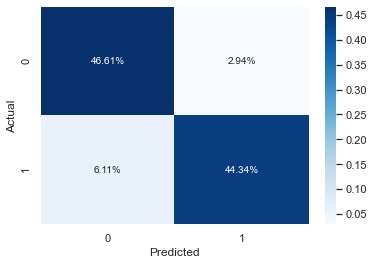

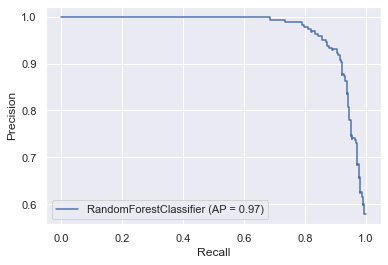

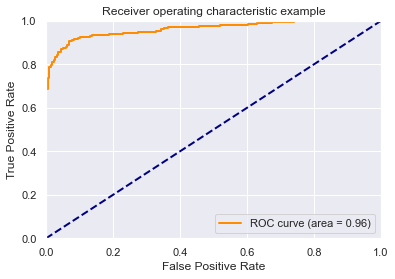

In [213]:
# RANDOM FOREST CLASSIFIER TUNED

RF_clf = RandomForestClassifier(bootstrap=True,
                                 max_depth=20,
                                 max_features='sqrt',
                                 min_samples_leaf=2,
                                 min_samples_split=2,
                                 n_estimators=1200)


# RF_clf = RandomForestClassifier(bootstrap=True,
#                                  max_depth=90,
#                                  max_features=3,
#                                  min_samples_leaf=3,
#                                  min_samples_split=8,
#                                  n_estimators=1000)


RF_clf.fit(Xs_train_sm,ys_train_sm)
ys_pred_sm = RF_clf.predict(Xs_test_sm)
display_scores(RF_clf, Xs_test_sm, ys_test_sm, ys_pred_sm)

                    feature     score
8          StockOptionLevel  0.067055
0             MonthlyIncome  0.065077
39    MaritalStatus_Married  0.056987
1           JobSatisfaction  0.054482
2   EnvironmentSatisfaction  0.054179
4            JobInvolvement  0.053868
14                      Age  0.046161
9          DistanceFromHome  0.042781
10     YearsWithCurrManager  0.038542
12       YearsInCurrentRole  0.037639


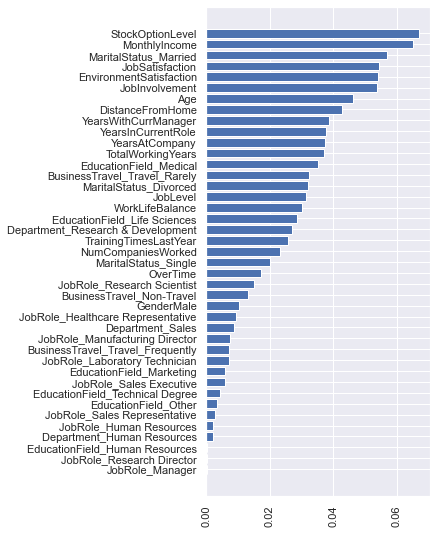

In [201]:
RF_score_df = display_feature_importance(RF_clf, X)


Accuracy is:  0.91
F1 score is:  0.91
Ave PR score:  0.97
              precision    recall  f1-score   support

        Stay       0.88      0.95      0.91       219
       Leave       0.95      0.87      0.91       223

    accuracy                           0.91       442
   macro avg       0.91      0.91      0.91       442
weighted avg       0.91      0.91      0.91       442



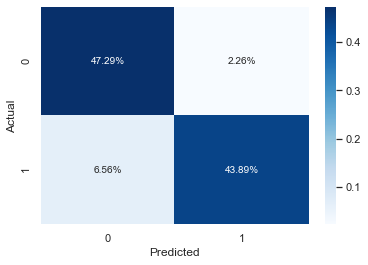

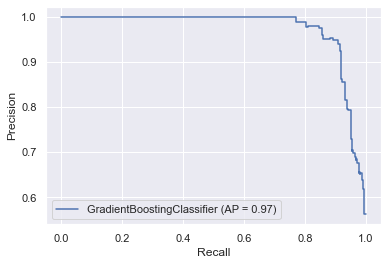

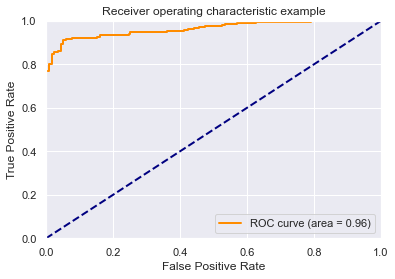

                              feature     score
8                    StockOptionLevel  0.159324
1                     JobSatisfaction  0.084308
0                       MonthlyIncome  0.071116
32             EducationField_Medical  0.060230
9                    DistanceFromHome  0.051647
30       EducationField_Life Sciences  0.045160
14                                Age  0.043995
2             EnvironmentSatisfaction  0.037068
27  Department_Research & Development  0.037035
38             MaritalStatus_Divorced  0.035326


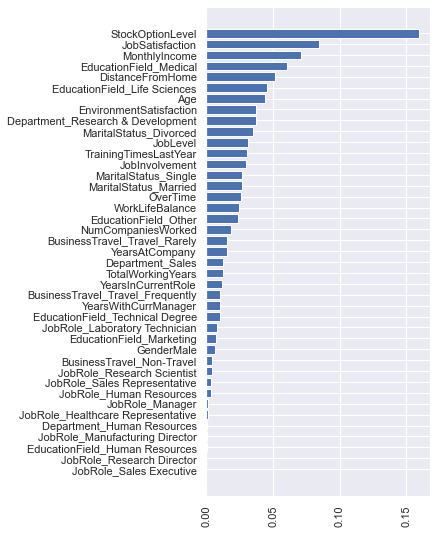

In [212]:
#GRADIENT BOOSTING


# {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 250}
#  0.1, 'max_depth': 1, 'n_estimators': 500
# 'learning_rate': 1, 'max_depth': 5, 'n_estimators': 500
            
GB_clf = GradientBoostingClassifier(random_state=42, 
                                    learning_rate=1, 
                                    max_depth=5, 
                                    n_estimators=500)


GB_clf.fit(Xs_train_sm,ys_train_sm)
ys_pred_sm = GB_clf.predict(Xs_test_sm)
display_scores(GB_clf, Xs_test_sm, ys_test_sm, ys_pred_sm)
GB_score_df = display_feature_importance(GB_clf, X)

Accuracy is:  0.92
F1 score is:  0.92
Ave PR score:  0.97
              precision    recall  f1-score   support

        Stay       0.88      0.97      0.92       219
       Leave       0.97      0.87      0.92       223

    accuracy                           0.92       442
   macro avg       0.92      0.92      0.92       442
weighted avg       0.92      0.92      0.92       442



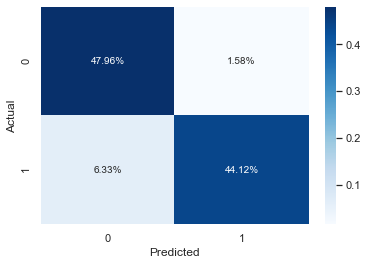

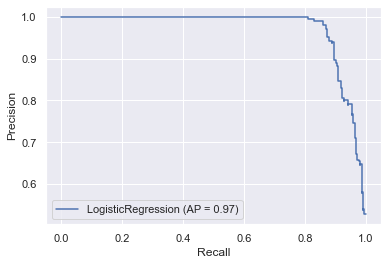

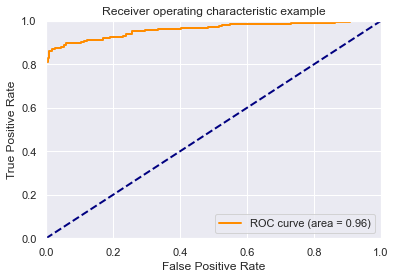

In [214]:

log_model = LogisticRegression(solver='newton-cg',C=1.0,penalty='l2')

log_model.fit(Xs_train_sm,ys_train_sm)
ys_pred_sm = log_model.predict(Xs_test_sm)
display_scores(log_model, Xs_test_sm, ys_test_sm, ys_pred_sm)


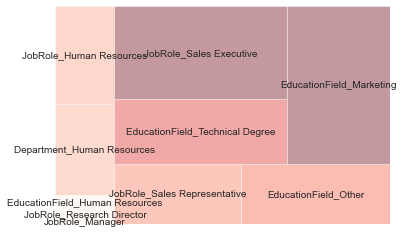

In [205]:
#libraries
import matplotlib
import squarify # pip install squarify (algorithm for treemap)

size_list = list(RF_score_df.score.head(10))
label_list = list(RF_score_df.feature.head(10))

# create a color palette, mapped to these values
cmap = matplotlib.cm.Reds
mini=min(size_list)
maxi=max(size_list)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in size_list]

# colors=['Red','Yellow','Green', 'Purple']

squarify.plot(sizes=size_list, label=label_list, color=colors, alpha=.4 )
plt.axis('off')
plt.show()
